# Quantum Algorithms, Applications & Qiskit Runtime
## *The aftermath of "The Great Primitives Refactoring"*
Elena Peña Tapia (ept@zurich.ibm.com) & Max Rossmannek (oss@zurich.ibm.com)
### Quantum Practitioners Forum 2022

***

<a id='top'></a>
## Our Agenda Today (90 min session):

### 1. [Introduction](#intro)
### 2. [Algorithms](#algos)
### 3. [Applications: Machine Learning. Performance](#ml)
### 4. [Applications: Nature. Performance](#nature)
### 5. [Wrap-Up](#wrapup)

***

<a id='intro'></a>
# 1. Introduction
<font color='gray'>2. Algorithms</font>  

<font color='gray'>3. Applications: Machine Learning. Performance</font>  

<font color='gray'>4. Applications: Nature. Performance</font>  

<font color='gray'>5. Wrap-Up</font>

[Top](#top)

***

<img src="imgs/roadmap.jpeg" width = 1600 height=1600 />

<img src="imgs/stack.png" width = 1300 height=1300 />

<img src="imgs/why.png" width = 1500 height=1500 />

<img src="imgs/primitives_zoo.png" width = 1500 height=1500 />

<a id='algos'></a>
<font color='gray'> 1. Introduction</font> 
# 2. Algorithms

<font color='gray'>3. Applications: Machine Learning. Performance</font>  

<font color='gray'>4. Applications: Nature. Performance</font>  

<font color='gray'>5. Wrap-Up</font>

[Top](#top)


<img src="imgs/zoo_before.png" width = 1300 height=1300 />

<img src="imgs/terra_changes.png" width = 1300 height=1300 />

<img src="imgs/zoo_after.png" width = 1300 height=1300 />

## Key takeaways:

#   

<img src="imgs/explore_1.png" width = 1300 height=1300 />

<img src="imgs/state_search.png" width = 1300 height=1300 />

## Key takeaways:

#   
<img src="imgs/explore_2.png" width = 1300 height=1300 />

<!-- ## Workflow 1: Ground State Search -->
### QI vs. Estimator `VQE`, minimal example


<table>
<tr>
<th style="text-align: center;">QuantumInstance VQE</th>
<th style="text-align: center;">Estimator VQE</th>
</tr>
<tr>
<td style="text-align: left;">

```python
from qiskit.algorithms.minimum_eigen_solvers import VQE
from qiskit.utils import QuantumInstance
from qiskit import Aer

qi = QuantumInstance(
    backend=Aer.get_backend('statevector_simulator'))
   
vqe = VQE(ansatz, optimizer, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(hamiltonian)
```
</td>
<td style="text-align: left;">

```python
# note change of namespace
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator

estimator = Estimator()
    
vqe = VQE(estimator, ansatz, optimizer)
result = vqe.compute_minimum_eigenvalue(hamiltonian)
```

</td>
</tr>
</table>

<!-- ## Workflow 1: Ground State Search -->
### QI vs. Estimator `VQE`: advanced example

<table>
<tr>
<th style="text-align: center; width:50%">Quantum Instance VQE</th>
<th style="text-align: center; width:50%">Estimator VQE</th>
</tr>
<tr>
<td style="text-align: left; width:50%">

```python
from qiskit import IBMQ
from qiskit.utils import QuantumInstance
from qiskit.opflow.gradients import Gradient
from qiskit.algorithms.minimum_eigen_solvers import VQE         

# define provider
IBMQ.load_account()
provider = IBMQ.get_provider(project="default")
device = provider.get_backend("ibm_geneva")
```
</td>
<td style="vertical-align: top; text-align: left; width:50%">

```python
from qiskit_ibm_runtime import QiskitRuntimeService, \
    Session, Estimator
from qiskit.algorithms.gradients import \ 
    FiniteDiffEstimatorGradient as FDEstimatorGrad
from qiskit.algorithms.minimum_eigensolvers import VQE
    
# define service
service = QiskitRuntimeService(channel="ibm_quantum")
```

</td>
</tr>
</table>

<table>
<tr/>
<tr>
<td style="vertical-align: top; text-align: left; width:50%">

```python
# define quantum instance
qi = QuantumInstance(backend=device)
    
# define gradient
gradient = Gradient(grad_method='fin_diff')

# run VQE
vqe = VQE(ansatz, optimizer,
          gradient=gradient, initial_point=init_pt, 
          quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(hamiltonian)
```
</td>
<td style="vertical-align: top; text-align: left; width:50%">

```python
# define session
with Session(service=service, backend="ibm_geneva") as session:
    
    # define estimator
    estimator = Estimator(session=session)

    # define gradient
    gradient = FDEstimatorGrad(estimator, epsilon=0.1)

    # run VQE
    vqe = VQE(estimator, ansatz, optimizer, 
              gradient=gradient, initial_point=init_pt)
    result = vqe.compute_minimum_eigenvalue(hamiltonian)
```

</td>
</tr>
</table>


### New Gradient Framework

In [1]:
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Operator

qc = RealAmplitudes(num_qubits=2, reps=1)  # 4 parameters
op = Operator.from_label("ZZ")

from qiskit.primitives import Estimator
from qiskit.algorithms.gradients import ParamShiftEstimatorGradient as PSEstimatorGrad

gradient = PSEstimatorGrad(estimator=Estimator())

import numpy as np

params = [np.pi / 4 for _ in qc.parameters]
grad_job = gradient.run([qc], [op], [params])
gradients = grad_job.result().gradients[0]

In [3]:
print(gradients)

[ 0.60355339 -0.60355339  0.25       -0.25      ]


In [2]:
print(grad_job.result())

EstimatorGradientResult(gradients=[array([ 0.60355339, -0.60355339,  0.25      , -0.25      ])], metadata=[{'parameters': [ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3])]}], options=Options())


Imports with new gradient framework:

<table>
<tr>
<th style="text-align: center;">Opflow Gradients</th>
<th style="text-align: center;">Primitive Gradients</th>
</tr>
<tr>
<td style="text-align: left;">

```python

from qiskit.opflow.gradients import Gradient

gradient = Gradient(grad_method='fin_diff')
gradient = Gradient(grad_method='lin_comb')
gradient = Gradient(grad_method='param_shift')

```
</td>
<td style="text-align: left;">

```python

from qiskit.algorithms.gradients import \
    FiniteDiffEstimatorGradient \
    FiniteDiffSamplerGradient \
    LinCombEstimatorGradient \
    LinCombSamplerGradient \
    ParamShiftEstimatorGradient \
    ParamShiftSamplerGradient \
    SPSAEstimatorGradient \
    SPSASamplerGradient \
```
</td>
</tr>
</table>

### Case Study: `VQE`

#### Using `Estimator` for energy evaluation in `VQE`

In `VQE.compute_minimum_eigenvalues()`:

```python
def compute_minimum_eigenvalues(operator):
    ...
    opt_result = self.optimizer.minimize(
                     fun=evaluate_energy, x0=initial_point)
    ...
```
```python
def evaluate_energy(parameters):

    estimator_job = self.estimator.run(
                    circuits = [self.ansatz], observables=[operator], 
                    parameter_values=[parameters]
                    )
    estimator_result = estimator_job.result()
    values = estimator_result.values
                
    return values[0]
```

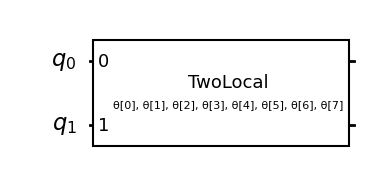

In [8]:
# optimizer, ansatz --> defined as usual
from qiskit.algorithms.optimizers import GradientDescent
from qiskit.circuit.library import TwoLocal

num_qubits = 2
ansatz = TwoLocal(num_qubits, "ry", "cz")
optimizer = GradientDescent(maxiter=10)

# define initial point
init_pt = [-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]

# hamiltonian/operator --> use SparsePauliOp or Operator
from qiskit.quantum_info import SparsePauliOp

hamiltonian = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)
ansatz.draw("mpl", style="bw")

In [5]:
# alternatively, the hamiltonian can be defined as:
from qiskit.quantum_info.operators import Operator

hamiltonian = Operator(
    [
        [-1.06365335, 0, 0, 0.1809312],
        [0, -1.83696799, 0.1809312, 0],
        [0, 0.1809312, -0.24521829, 0],
        [0.1809312, 0, 0, -1.06365335],
    ]
)

In [6]:
# save accounts
# from tokens import IQX_TOKEN, CLOUD_TOKEN, CRN
# QiskitRuntimeService.save_account(channel="ibm_quantum", token=IQX_TOKEN, overwrite=True)
# QiskitRuntimeService.save_account(channel="ibm_cloud", token=CLOUD_TOKEN, instance=CRN, overwrite=True)

In [7]:
# RUNTIME PRIMITIVES
from qiskit_ibm_runtime import Estimator, QiskitRuntimeService, Session

service = QiskitRuntimeService(channel="ibm_quantum")

with Session(service, backend="ibmq_qasm_simulator") as session:

    estimator = Estimator(session=session)

    # define gradient
    from qiskit.algorithms.gradients import (
        ParamShiftEstimatorGradient as PSEstimatorGrad,
    )

    gradient = PSEstimatorGrad(estimator)

    # run VQE
    from qiskit.algorithms.minimum_eigensolvers import VQE

    vqe = VQE(estimator, ansatz, optimizer, gradient=gradient, initial_point=init_pt)
    result = vqe.compute_minimum_eigenvalue(hamiltonian)

In [8]:
# see results
print(result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 0,
    'eigenvalue': -1.06683131443,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x7fa85134ac70>,
    'optimal_parameters': {   ParameterVectorElement(θ[0]): -0.1128075762551,
                              ParameterVectorElement(θ[1]): -0.08161268373337502,
                              ParameterVectorElement(θ[7]): -0.07836734584550001,
                              ParameterVectorElement(θ[6]): -0.109432550153025,
                              ParameterVectorElement(θ[2]): -0.11121338580415,
                              ParameterVectorElement(θ[5]): -0.08355223966615,
                              ParameterVectorElement(θ[4]): -0.11426588989845,
                              ParameterVectorElement(θ[3]): -0.079963318388175},
    'optimal_point': array([-0.11280758, -0.08161268, -0.11121339, -0.07996332, -0.11426589,
       -0.08355224, -0.10943255, -0.07836735]),
    'optimal_valu

In [9]:
# REFERENCE PRIMITIVES
from qiskit.primitives import Estimator

# define estimator
estimator = Estimator()

# define gradient
from qiskit.algorithms.gradients import FiniteDiffEstimatorGradient as FDEstimatorGrad

gradient = FDEstimatorGrad(estimator, epsilon=0.01)

# run VQE
from qiskit.algorithms.minimum_eigensolvers import VQE

vqe = VQE(estimator, ansatz, optimizer, gradient=gradient, initial_point=init_pt)
result = vqe.compute_minimum_eigenvalue(hamiltonian)

# see results
print(result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 0,
    'eigenvalue': -1.064941089849978,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x7fa82058f400>,
    'optimal_parameters': {   ParameterVectorElement(θ[0]): -0.11293754920156243,
                              ParameterVectorElement(θ[1]): -0.08165430016819078,
                              ParameterVectorElement(θ[7]): -0.07853610021465576,
                              ParameterVectorElement(θ[6]): -0.10936993530110342,
                              ParameterVectorElement(θ[2]): -0.11129343856755183,
                              ParameterVectorElement(θ[5]): -0.08369157461493806,
                              ParameterVectorElement(θ[4]): -0.11427739939633,
                              ParameterVectorElement(θ[3]): -0.07992223618393204},
    'optimal_point': array([-0.11293755, -0.0816543 , -0.11129344, -0.07992224, -0.1142774 ,
       -0.08369157, -0.10936994, -0.0785361 ]),

### New State Fidelities

$ statefidelity = |\langle\psi(x)|\phi(y)\rangle|^2 $

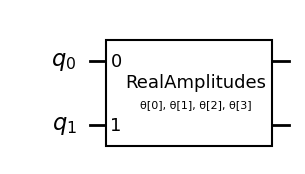

In [7]:
from qiskit.circuit.library import RealAmplitudes

qc1 = RealAmplitudes(2, reps=1)  # 4 parameters
qc1.draw(output="mpl", style="bw")

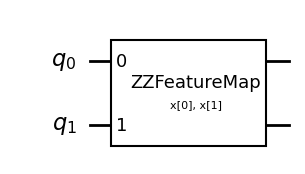

In [6]:
from qiskit.circuit.library import ZZFeatureMap

qc2 = ZZFeatureMap(2, reps=1)  # 2 parameters
qc2.draw(output="mpl", style="bw")

In [14]:
# instantiate fidelity
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.primitives import Sampler

fidelity = ComputeUncompute(sampler=Sampler())

# define param. values
values1 = [[1, 2, 3, 4], [4, 3, 2, 1], [0, 0, 0, 0]]
values2 = [[7, 8], [1, 2], [3, 4]]

# run job
job = fidelity.run([qc1] * 3, [qc2] * 3, values1, values2)

# retrieve results
results = job.result().fidelities
print(results)

[0.2550267968270442, 0.03806566537280539, 0.2499999999999999]


The `ComputeUncompute` circuit construction is simple yet poweful. As seen in:

*[1] Havlíček, V., Córcoles, A. D., Temme, K., Harrow, A. W., Kandala,
    A., Chow, J. M., & Gambetta, J. M. (2019). 
    Supervised learning with quantum-enhanced feature spaces. 
    Nature, 567(7747), 209-212.
    arXiv:1804.11326v2*

```python
def create_fidelity_circuit(
    self, 
    circuit_1: QuantumCircuit, 
    circuit_2: QuantumCircuit ) -> QuantumCircuit:

    circuit = circuit_1.compose(circuit_2.inverse())
    circuit.measure_all()

    return circuit
```

### Case Study: `SamplingVQE` + `QNSPSA`

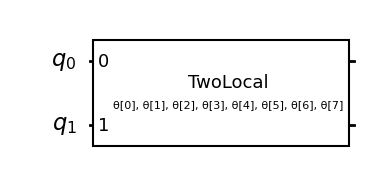

In [5]:
# define hamiltonian/operator --> diagonalized op.
from qiskit.quantum_info import SparsePauliOp

hamiltonian = SparsePauliOp(["ZZ", "IZ", "II"], coeffs=[1, -0.5, 0.12])

# define ansatz
from qiskit.circuit.library import TwoLocal

num_qubits = 2
ansatz = TwoLocal(num_qubits, "ry", "cz")
ansatz.draw("mpl", style="bw")

In [11]:
from qiskit.algorithms.optimizers import QNSPSA
from qiskit.primitives import Sampler
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE

with Session(service, backend="ibmq_qasm_simulator") as session:

    # define QNSPSA optimizer
    sampler = Sampler(session=session)
    fidelity = QNSPSA.get_fidelity(sampler=sampler, circuit=ansatz)
    optimizer = QNSPSA(fidelity=fidelity, maxiter=100)

    # run SamplingVQE
    vqe = SamplingVQE(sampler, ansatz, optimizer)
    result = vqe.compute_minimum_eigenvalue(hamiltonian)
    print(result)

SamplingMinimumEigensolverResult:
	Eigenvalue: -1.3799675933837992
	Best measurement
: {'state': 2, 'bitstring': '10', 'value': (-1.38+0j), 'probability': 0.9999935260863243}



### Case Study: `VQD`

In [80]:
# set up ansatz
from qiskit.circuit.library import TwoLocal

ansatz = TwoLocal(rotation_blocks=["ry", "rz"], entanglement_blocks="cz")

# set up operator
from qiskit.quantum_info import SparsePauliOp

h2_op = SparsePauliOp(
    ["II", "IZ", "ZI", "ZZ", "XX"],
    coeffs=[
        -1.052373245772859,
        0.39793742484318045,
        -0.39793742484318045,
        -0.01128010425623538,
        0.18093119978423156,
    ],
)

In [81]:
# define optimizer
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=10)

# define estimator and fidelity instance
from qiskit_ibm_runtime import Sampler, Estimator, Session, QiskitRuntimeService
from qiskit.algorithms.state_fidelities import ComputeUncompute

service = QiskitRuntimeService(channel="ibm_quantum")

with Session(service, backend="simulator_statevector") as session:
    # multiple primitives within session
    estimator = Estimator(session=session)
    fidelity = ComputeUncompute(Sampler(session=session))

    # run VQD
    from qiskit.algorithms.eigensolvers import VQD

    vqd = VQD(estimator, fidelity, ansatz, optimizer, k=2, betas=[0.5, 0.5])
    result = vqd.compute_eigenvalues(h2_op)
    eigenvalues = result.eigenvalues
    print(eigenvalues)

[-1.40384761+0.j -1.36871391+0.j]


#### How is the energy evaluated in `VQD`?

In `VQD.compute_eigenvalues()`:

```python
def compute_eigenvalues(operator):
    ...
    opt_result = self.optimizer.minimize(
                 fun=evaluate_energy, x0=initial_point)
    ...
```


In `evaluate_energy()` (**leveraging async**):

```python
def evaluate_energy(parameters):
    estimator_job = self.estimator.run(
                        circuits=[self.ansatz], observables=[operator], 
                        parameter_values=[parameters])
```
```python
    if step > 1:
        # Compute overlap cost
        fidelity_job = self.fidelity.run(
                            [self.ansatz] * len(prev_circs), 
                             prev_circs,
                            [parameters] * len(prev_circs), 
                            [prev_states[:-1]])
```
```python
        estimator_result = estimator_job.result()
        values = estimator_result.values
        costs = fidelity_job.result().fidelities
        for (state, cost) in zip(range(step - 1), costs):
            values += np.real(betas[state] * cost)
    else:
        estimator_result = estimator_job.result()
        values = estimator_result.values
    
    return values[0]
```


## Wrap-Up
<img src="imgs/terra_changes.png" width = 1300 height=1300 />


## Wrap-Up
<img src="imgs/takeaways.png" width = 1300 height=1300 />


## From Algorithms to Applications

<img src="imgs/pipeline.png" width = 1300 height=1300 />

## From Algorithms to Applications

<img src="imgs/quadratic-pipeline.png" width = 1300 height=1300 />

<a id='ml'></a>

<font color='gray'> 1. Introduction</font> 

<font color='gray'> 2. Algorithms</font> 

# 3. Applications: Machine Learning. Performance

<font color='gray'>4. Applications: Nature. Performance</font>  

<font color='gray'>5. Wrap-Up</font>

[Top](#top)



<img src="imgs/ml-pipeline.png" width = 1300 height=1300 />

<img src="imgs/qml.png" width = 1300 height=1300 />

<img src="imgs/qml2.png" width = 1300 height=1300 />

## Case Study: Classification with `SamplerQNN`

In [11]:
import numpy as np
import matplotlib.pyplot as plt

num_inputs = 2
num_samples = 20
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)
y = 2 * y01 - 1
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

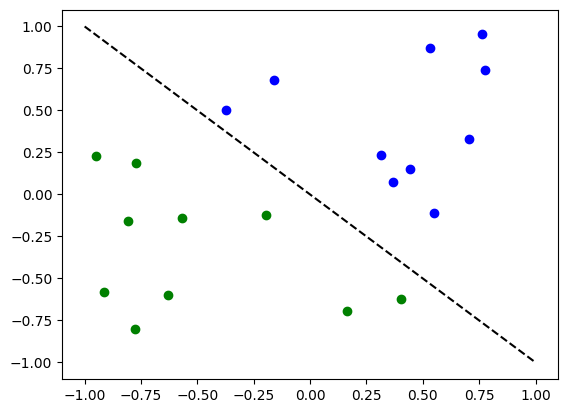

In [12]:
# Plot dataset
for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")

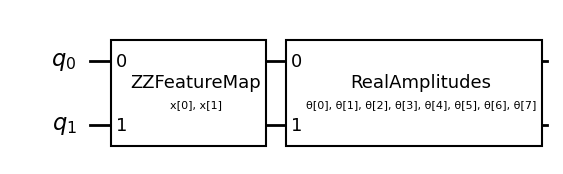

In [4]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes

# construct QNN
qc = QuantumCircuit(2)
feature_map = ZZFeatureMap(2)
ansatz = RealAmplitudes(2)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
qc.draw("mpl", style="bw")

In [8]:
from qiskit.primitives import Sampler
from qiskit_machine_learning.neural_networks import SamplerQNN

sampler = Sampler()
qnn1 = SamplerQNN(
    sampler=sampler,
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

In [13]:
# callback function that draws a live plot when the .fit() method is called
from IPython.display import clear_output


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [14]:
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit.algorithms.optimizers import COBYLA

# construct neural network classifier
estimator_classifier = NeuralNetworkClassifier(
    qnn1, optimizer=COBYLA(maxiter=60), callback=callback_graph)

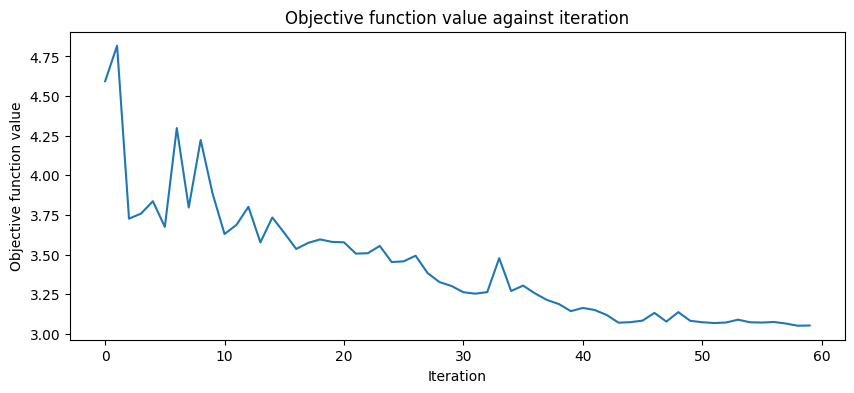

0.2

In [15]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (10, 4)

# fit classifier to data
estimator_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
estimator_classifier.score(X, y)

## Primitives Benchmark: SamplerQNN vs. CircuitQNN

In [17]:
from matplotlib import pyplot as plt
import numpy as np

plt.rcParams.update({"font.size": 15})

benchmark_data = {}
benchmark_data["Primitives"] = (2.272801638, 1.1564188, 0.125061715)
benchmark_data["Legacy Jobs"] = (5.794027249, 4.741929928, 0.330515218)

X = ["Primitives", "Legacy Jobs"]
X_axis = np.arange(len(X))

qnn_benchmark = plt.figure(figsize=(10, 6))
# plt.yscale("log")
plt.ylabel("Time / circuit [s]")
plt.xticks(X_axis, X)
plt.suptitle("Time/circuit")
plt.title("1-qubit QNN on ibmq_qasm_simulator", fontsize="small")
for x, (key, val) in enumerate(benchmark_data.items()):
    line_1 = plt.bar(x - 0.2, val[0], 0.2, color="royalblue")
    line_2 = plt.bar(x, val[1], 0.2, color="grey")
    line_3 = plt.bar(x + 0.2, val[2], 0.2, color="lightseagreen")

plt.legend(
    handles=[line_1, line_2, line_3],
    labels=["1 sample", "20 samples, batch size 1", "20 samples, batch size 20"],
)
plt.close()

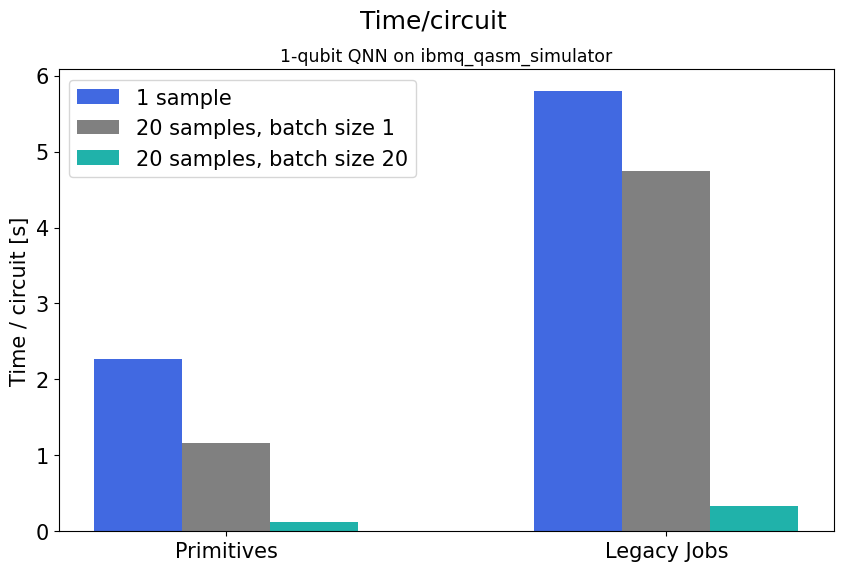

In [18]:
qnn_benchmark

## Case Study: Hybrid QNN with `EstimatorQNN` and `TorchConnector`

In [1]:
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np

# Train Dataset
# -------------

# Set train shuffle seed (for reproducibility)
manual_seed(42)

batch_size = 100
n_samples = 100  # We will concentrate on the first 100 samples

# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples],
    np.where(X_train.targets == 1)[0][:n_samples],
)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

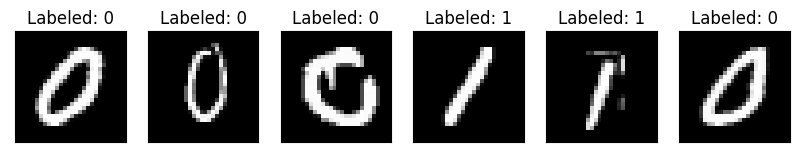

In [2]:
import matplotlib.pyplot as plt

n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

# while n_samples_show > 0:
images, targets = data_iter.__next__()

for i in range(n_samples_show):
    axes[n_samples_show - 1].imshow(images[i].numpy().squeeze(), cmap="gray")
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[i].item()))

    n_samples_show -= 1

In [3]:
# Define Hybrid QNN architecture

from qiskit_machine_learning.connectors import TorchConnector
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d
)
import torch.nn.functional as F

class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)
        self.qnn = TorchConnector(qnn)
        self.fc3 = Linear(1, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x)) 
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)
        x = self.fc3(x)
        return cat((x, 1 - x), -1)

In [4]:
# Define and create QNN

from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.neural_networks import EstimatorQNN


def create_qnn(estimator):
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    qc = QuantumCircuit(2)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    qnn = EstimatorQNN(
        estimator=estimator,
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn

In [5]:
# Run training

from qiskit_ibm_runtime import Estimator, QiskitRuntimeService, Session
from qiskit_machine_learning.neural_networks import SamplerQNN
import torch.optim as optim

loss_list = []
state_dict = {}

service = QiskitRuntimeService(channel="ibm_quantum")
with Session(service=service, backend="simulator_statevector") as session:
    estimator = Estimator(session=session)
    qnn = create_qnn(estimator)
    model = Net(qnn)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_func = NLLLoss()

    # Start training
    epochs = 10
    model.train()
    for epoch in range(epochs):
        total_loss = []
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad(set_to_none=True)
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            optimizer.step()
            total_loss.append(loss.item())
        loss_list.append(sum(total_loss) / len(total_loss))
        print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

    # Save state dict to transfer between sessions
    state_dict = model.state_dict()

Training [10%]	Loss: -0.3839
Training [20%]	Loss: -0.6355
Training [30%]	Loss: -0.8439
Training [40%]	Loss: -1.0150
Training [50%]	Loss: -1.1223
Training [60%]	Loss: -1.1380
Training [70%]	Loss: -1.1374
Training [80%]	Loss: -1.1745
Training [90%]	Loss: -1.2461
Training [100%]	Loss: -1.2532


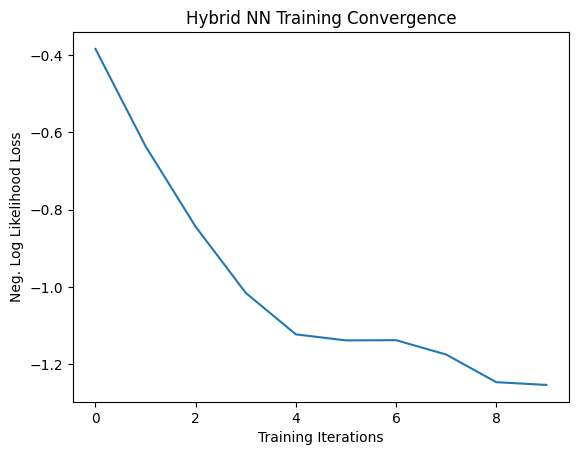

In [6]:
# Plot loss convergence

plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

In [7]:
# Test Dataset
# -------------

# Set test shuffle seed (for reproducibility)
# manual_seed(5)

n_samples = 50

# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_test.targets == 0)[0][:n_samples],
    np.where(X_test.targets == 1)[0][:n_samples],
)
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

In [54]:
# Run Evaluation

with Session(service=service, backend="simulator_statevector") as session:

    estimator = Estimator(session=session)
    qnn = create_qnn(estimator)
    model = Net(qnn)
    model.load_state_dict(state_dict)
    model.eval()

    with no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            if len(output.shape) == 1:
                output = output.reshape(1, *output.shape)

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            loss = loss_func(output, target)
            total_loss.append(loss.item())

        print(
            "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
                sum(total_loss) / len(total_loss),
                correct / len(test_loader) / batch_size * 100,
            )
        )

Performance on test data:
	Loss: -1.2853
	Accuracy: 100.0%


## Primitives Benchmark: Gradients

<!-- - Test with RealAmplitudes ansatz, 10 qubits
- Normalized execution time: **primitive gradients** are ~20 times faster than **opflow gradients**

 -->

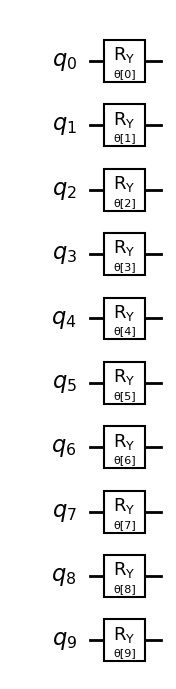

In [2]:
from qiskit.circuit.library import RealAmplitudes

qc = RealAmplitudes(10, reps=0)
qc.decompose().draw("mpl", style="bw")

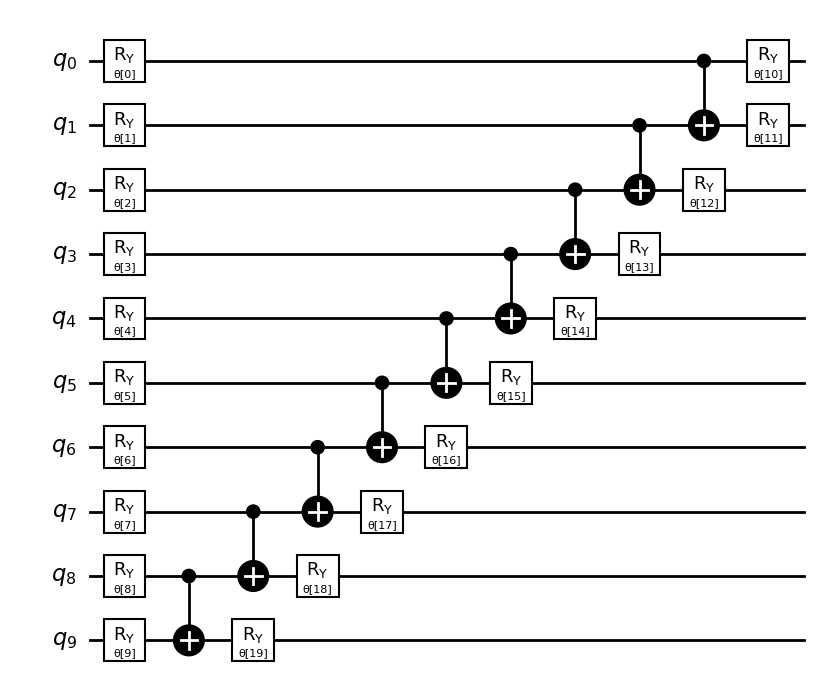

In [3]:
qc = RealAmplitudes(10, reps=1)
qc.decompose().draw("mpl", style="bw")

In [46]:
from dataclasses import dataclass


@dataclass
class ElapsedTime:
    name: str
    forward: list[float]
    gradient: list[float]
    forward_avg: float
    gradient_avg: float
    normalized_exec_time: float


def calc_elapsed_time(name, forward, gradient):
    forward_avg = np.mean(forward)
    gradient_avg = np.mean(gradient)
    normalized_exec_time = gradient_avg / forward_avg
    return ElapsedTime(
        name=name,
        forward=forward,
        gradient=gradient,
        forward_avg=forward_avg,
        gradient_avg=gradient_avg,
        normalized_exec_time=normalized_exec_time,
    )


compare_time = {
    "rep0": [
        ElapsedTime(
            name="opflow_rep0",
            forward=[
                0.06511831283569336,
                0.02434515953063965,
                0.02210402488708496,
                0.02234196662902832,
                0.02210688591003418,
            ],
            gradient=[
                5.283751964569092,
                5.209047079086304,
                5.4985339641571045,
                5.517637014389038,
                5.509497165679932,
            ],
            forward_avg=0.031203269958496094,
            gradient_avg=5.403693437576294,
            normalized_exec_time=173.1771524190837,
        ),
        ElapsedTime(
            name="primitive_rep0",
            forward=[
                0.006824970245361328,
                0.005753040313720703,
                0.005385160446166992,
                0.005394935607910156,
                0.0054378509521484375,
            ],
            gradient=[
                0.0878751277923584,
                0.08877396583557129,
                0.0876309871673584,
                0.08665871620178223,
                0.08631706237792969,
            ],
            forward_avg=0.005759191513061523,
            gradient_avg=0.087451171875,
            normalized_exec_time=15.184626466521499,
        ),
    ],
    "rep1": [
        ElapsedTime(
            name="opflow_rep1",
            forward=[
                0.03152799606323242,
                0.028979063034057617,
                0.029180049896240234,
                0.031157732009887695,
                0.028755903244018555,
            ],
            gradient=[
                14.250807046890259,
                14.462125062942505,
                14.768449068069458,
                14.31602931022644,
                14.225275993347168,
            ],
            forward_avg=0.029920148849487304,
            gradient_avg=14.404537296295166,
            normalized_exec_time=481.43267497621406,
        ),
        ElapsedTime(
            name="primitive_rep1",
            forward=[
                0.010058164596557617,
                0.00887298583984375,
                0.009077072143554688,
                0.008844852447509766,
                0.00872492790222168,
            ],
            gradient=[
                0.26814794540405273,
                0.24917030334472656,
                0.24268603324890137,
                0.23812294006347656,
                0.24033617973327637,
            ],
            forward_avg=0.0091156005859375,
            gradient_avg=0.24769268035888672,
            normalized_exec_time=27.172392869099433,
        ),
    ],
    "rep5": [
        ElapsedTime(
            name="opflow_rep5",
            forward=[
                0.05146980285644531,
                0.04968690872192383,
                0.049668073654174805,
                0.04969286918640137,
                0.049581050872802734,
            ],
            gradient=[
                80.1846718788147,
                78.70231223106384,
                86.17645502090454,
                80.7437961101532,
                82.51665711402893,
            ],
            forward_avg=0.05001974105834961,
            gradient_avg=81.66477847099304,
            normalized_exec_time=1632.6509642608605,
        ),
        ElapsedTime(
            name="primitive_rep5",
            forward=[
                0.027094125747680664,
                0.02516007423400879,
                0.024489879608154297,
                0.024899959564208984,
                0.02542710304260254,
            ],
            gradient=[
                1.954977035522461,
                1.73030686378479,
                1.6468899250030518,
                1.6271309852600098,
                1.6472198963165283,
            ],
            forward_avg=0.025414228439331055,
            gradient_avg=1.7213049411773682,
            normalized_exec_time=67.72997044889536,
        ),
    ],
    "rep10": [
        ElapsedTime(
            name="opflow_rep10",
            forward=[
                0.08776998519897461,
                0.08373188972473145,
                0.08428502082824707,
                0.08484101295471191,
                0.08399224281311035,
            ],
            gradient=[
                242.2490210533142,
                245.59403204917908,
                243.77166318893433,
                246.31664299964905,
                251.7241768836975,
            ],
            forward_avg=0.08492403030395508,
            gradient_avg=245.93110723495482,
            normalized_exec_time=2895.895382670049,
        ),
        ElapsedTime(
            name="primitive_rep10",
            forward=[
                0.052000999450683594,
                0.04622912406921387,
                0.047102928161621094,
                0.04625082015991211,
                0.04765200614929199,
            ],
            gradient=[
                4.8781890869140625,
                4.677199125289917,
                4.344880819320679,
                4.341502904891968,
                4.194723129272461,
            ],
            forward_avg=0.04784717559814453,
            gradient_avg=4.487299013137817,
            normalized_exec_time=93.78398948404867,
        ),
    ],
}

In [70]:
x = [0, 1, 5, 10]
# opflow_forward = [v[0].forward_avg for k, v in compare_time.items()]
opflow_gradient = [v[0].gradient_avg for k, v in compare_time.items()]
primitive_gradient = [v[1].gradient_avg for k, v in compare_time.items()]

grad_bench, ax = plt.subplots()

# Using set_dashes() to modify dashing of an existing line
(line1,) = ax.plot(x, opflow_gradient, "go--", label="opflow gradient avg.")
# line1.set_dashes([2, 2, 10, 2])  # 2pt line, 2pt break, 10pt line, 2pt break

# Using plot(..., dashes=...) to set the dashing when creating a line
(line2,) = ax.plot(x, primitive_gradient, "o--", label="primitive gradient avg.")

ax.set(xlabel="Circuit depth", ylabel="Time [s]", title="Total gradient runtime")

ax.legend()
plt.close()

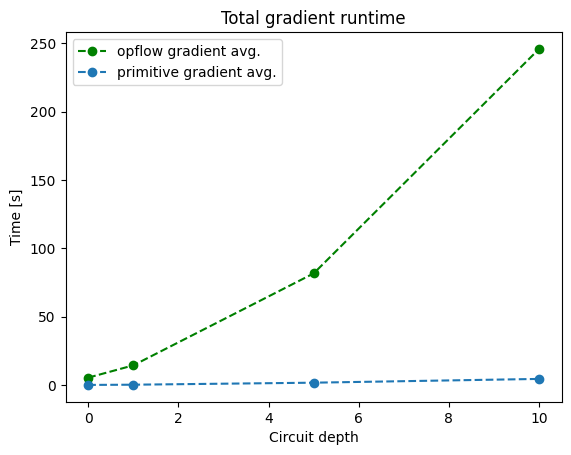

In [71]:
grad_bench

In [72]:
x = [0, 1, 5, 10]
# opflow_forward = [v[0].forward_avg for k, v in compare_time.items()]
opflow_gradient = [v[0].normalized_exec_time for k, v in compare_time.items()]
primitive_gradient = [v[1].normalized_exec_time for k, v in compare_time.items()]

grad_bench_2, ax = plt.subplots()

# Using set_dashes() to modify dashing of an existing line
(line1,) = ax.plot(x, opflow_gradient, "go--", label="opflow normalized exec time")
# line1.set_dashes([2, 2, 10, 2])  # 2pt line, 2pt break, 10pt line, 2pt break

# Using plot(..., dashes=...) to set the dashing when creating a line
(line2,) = ax.plot(x, primitive_gradient, "o--", label="primitive normalized exec time")

ax.set(xlabel="Circuit depth", ylabel="Time [s]", title="Normalized gradient runtime")

ax.legend()
plt.close()

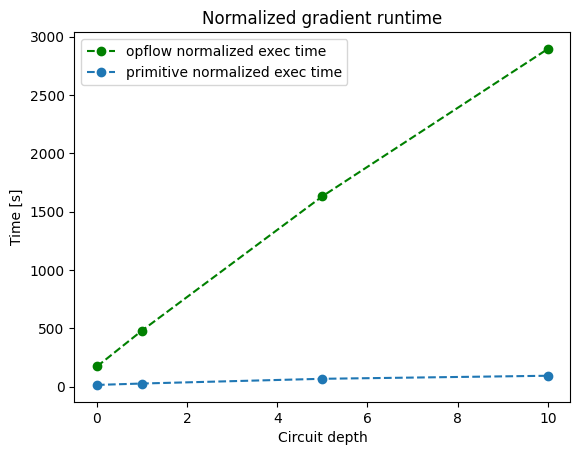

In [73]:
grad_bench_2

## Case Study: `FidelityQuantumKernel`

In [3]:
from qiskit_machine_learning.datasets import ad_hoc_data

adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

In [4]:
from matplotlib import pyplot as plt
import numpy as np

dataset_fig = plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap="RdBu",
    extent=[0, 2 * np.pi, 0, 2 * np.pi],
)
plt.title("Ad hoc dataset for classification")
plt.close()

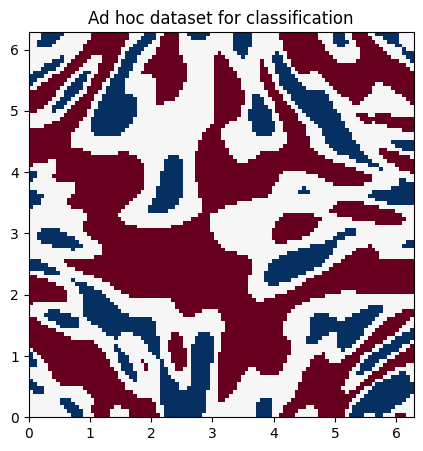

In [5]:
dataset_fig

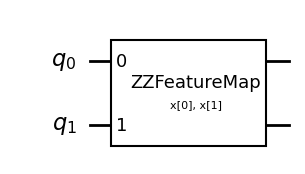

In [7]:
from qiskit.circuit.library import ZZFeatureMap

adhoc_feature_map = ZZFeatureMap(
    feature_dimension=adhoc_dimension, reps=2, entanglement="linear"
)
adhoc_feature_map.draw("mpl", style="bw")

In [8]:
from qiskit_ibm_runtime import Sampler, Session, QiskitRuntimeService
from qiskit_machine_learning.algorithms import QSVC
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

adhoc_matrix_train, adhoc_matrix_test = [], []
service = QiskitRuntimeService(channel="ibm_quantum")
with Session(service=service, backend="simulator_statevector") as session:

    sampler = Sampler(session=session)
    fidelity = ComputeUncompute(sampler=sampler)
    adhoc_kernel = FidelityQuantumKernel(
        fidelity=fidelity, feature_map=adhoc_feature_map
    )
    qsvc = QSVC(quantum_kernel=adhoc_kernel)
    qsvc.fit(train_features, train_labels)
    qsvc_score = qsvc.score(test_features, test_labels)
    print(f"QSVC classification test score: {qsvc_score}")

    adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=train_features)
    adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=test_features, y_vec=train_features)

QSVC classification test score: 1.0


In [9]:
plt.rcParams.update({"font.size": 10})

adhoc_fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(
    np.asmatrix(adhoc_matrix_train),
    interpolation="nearest",
    origin="upper",
    cmap="Blues",
)
axs[0].set_title("Ad hoc training kernel matrix")
axs[1].imshow(
    np.asmatrix(adhoc_matrix_test), interpolation="nearest", origin="upper", cmap="Reds"
)
axs[1].set_title("Ad hoc testing kernel matrix")
plt.close()

In [13]:
from sklearn.svm import SVC

adhoc_svc = SVC(kernel="precomputed")
adhoc_svc.fit(adhoc_matrix_train, train_labels)
adhoc_score = adhoc_svc.score(adhoc_matrix_test, test_labels)
print(f"Precomputed kernel classification test score: {adhoc_score}")

Precomputed kernel classification test score: 1.0


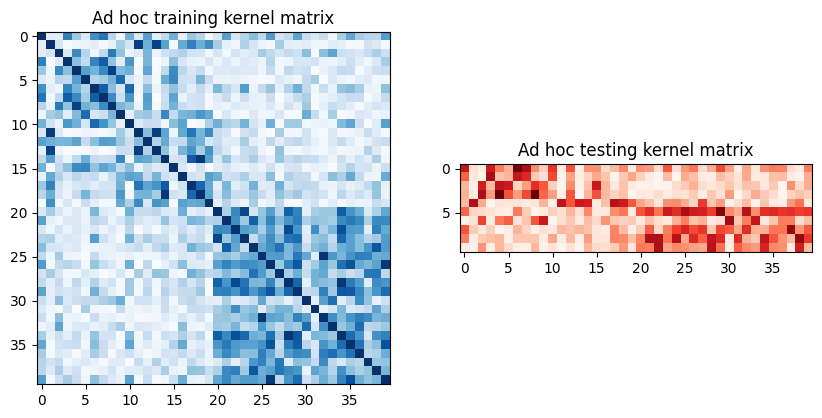

In [14]:
adhoc_fig

<a id='nature'></a>

<font color='gray'> 1. Introduction</font> 

<font color='gray'> 2. Algorithms

<font color='gray'> 3. Applications: Machine Learning. Performance</font> 

# 4. Applications: Nature. Performance

<font color='gray'>5. Wrap-Up</font>

[Top](#top)

<img src="imgs/electronic-pipeline.png" width = 1300 height=1300 />

<img src="imgs/nature.png" width = 1300 height=1300 />

## Electronic Structure

### Driver-based: Qiskit Nature controls the classical code

In [1]:
from qiskit_nature.second_q.drivers import PySCFDriver

driver = PySCFDriver(atom="Li 0 0 0; H 0 0 2.5", basis="sto-3g")

problem = driver.run()

In [2]:
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer

transformer = ActiveSpaceTransformer(4, 3)

problem = transformer.transform(problem)

In [3]:
# Legacy: problem = ElectronicStructureProblem(driver, [transformer])

In [4]:
from qiskit_nature.second_q.mappers import ParityMapper, QubitConverter

converter = QubitConverter(ParityMapper(), two_qubit_reduction=True)

In [5]:
from qiskit.algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.algorithms import VQEUCCFactory
from qiskit_nature.second_q.circuit.library import UCCSD

vqe_factory = VQEUCCFactory(Estimator(), UCCSD(), SLSQP())

In [6]:
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

algorithm = GroundStateEigensolver(converter, vqe_factory)

In [7]:
result = algorithm.solve(problem)
print(result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.408630223587
  - computed part:      -8.408630223587
  - ActiveSpaceTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.635012653104
> Total ground state energy (Hartree): -7.773617570483
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 4.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  4.72431531]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  6.45524134]
    - computed part:      [0.0  0.0  6.45524134]
    - ActiveSpaceTransformer extracted energy part: [0.0  0.0  0.0]
  > Dipole moment (a.u.): [0.0  0.0  -1.73092603]  Total: 1.73092603
                 (debye): [0.0  0.0  -4.39957471]  Total: 4.39957471
 


### Plugin-based: The classical code controls Qiskit Nature

In [8]:
from pyscf import gto, scf

mol = gto.M(atom="Li 0 0 0; H 0 0 2.5", basis="sto-3g")

h_f = scf.RHF(mol).run()

converged SCF energy = -7.7708736692219


In [9]:
from pyscf import mcscf

norb, nelec = 3, 4

cas = mcscf.CASCI(h_f, norb, nelec)

In [10]:
from qiskit.algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, VQEUCCFactory
from qiskit_nature.second_q.circuit.library import UCCSD
from qiskit_nature.second_q.mappers import ParityMapper, QubitConverter

# The same as before...

converter = QubitConverter(ParityMapper(), two_qubit_reduction=True)

vqe_factory = VQEUCCFactory(Estimator(), UCCSD(), SLSQP())

algorithm = GroundStateEigensolver(converter, vqe_factory)

In [11]:
from qiskit_nature_pyscf import QiskitSolver

# we can actually reuse the exact same GroundStateEigensolver from before
cas.fcisolver = QiskitSolver(algorithm)
cas.run()

CASCI E = -7.77361756473543  E(CI) = -8.40863021783943


## Primitives benchmark: `VQE`

<img src="imgs/vqe_bench_1.png" width = 600 height=600 />

<img src="imgs/vqe_bench_2.png" width = 800 height=800 />

## Case study: `AdaptVQE`

In [12]:
from qiskit.algorithms.minimum_eigensolvers import AdaptVQE

# let's get the VQE from the factory which we used before
vqe = vqe_factory.get_solver(problem, converter)

adapt_vqe = AdaptVQE(vqe)

# hot fix:
adapt_vqe.supports_aux_operators = lambda: True

In [13]:
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

algorithm = GroundStateEigensolver(converter, adapt_vqe)

In [14]:
adapt_cas = mcscf.CASCI(h_f, norb, nelec)
adapt_cas.fcisolver = QiskitSolver(algorithm)
adapt_cas.run()

CASCI E = -7.77361785074581  E(CI) = -8.40863050384981


In [6]:
from matplotlib import pyplot as plt

plt.rcParams.update({"font.size": 22})

benchmark_data = {}
benchmark_data["Primitives w/ Terra"] = (12.430068349838256, 0.6087867645499129)
benchmark_data["BackendPrimitives w/ Aer"] = (77.39233636856079, 42.532963066206804)
benchmark_data["Legacy w/ Aer"] = (3245.9162182807922, None)

adapt_vqe_benchmark = plt.figure(figsize=(14, 10))
plt.yscale("log")
plt.ylabel("Time [s]")
plt.xticks([])
plt.suptitle("Runtime comparison of AdaptVQE")
plt.title(
    r"Li-H ground state @ $2.5\AA$ w/ UCCSD in CAS(4, 3)",
    fontdict={"fontsize": "small"},
)

for x, (key, val) in enumerate(benchmark_data.items()):
    plt.bar(
        [x],
        [val[0]],
        [0.5],
        yerr=[val[1]] if val[1] is not None else None,
        label=key,
        color=(0.0, 0.0, 0.33 * (len(benchmark_data) - x), 0.8),
        error_kw={"ecolor": "black", "elinewidth": 2.5, "capsize": 5.0},
    )
plt.legend()
plt.close()

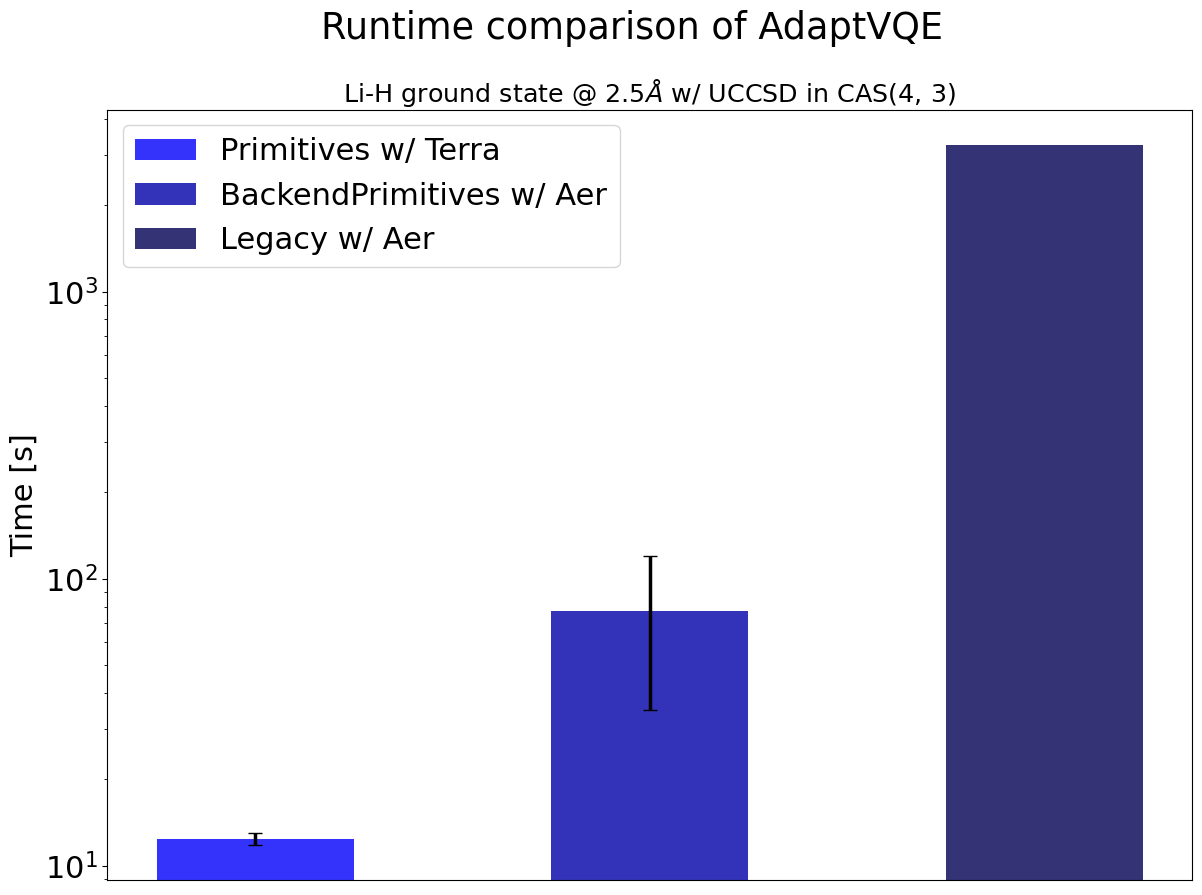

In [7]:
adapt_vqe_benchmark

## Vibrational Structure

In [1]:
from qiskit_nature.second_q.drivers import GaussianForcesDriver

driver = GaussianForcesDriver(
    logfile="""
 Input/Output information
 ------------------------
 Normal modes will be PRINTED in DESCENDING order (imag. freq. first)
   and sorted by irreducible representation
 The connection between this new numbering (A) and the one used before
   (H) is reported in the present equivalency table:
 ----+------+------+------+------+
 (H) |     1|     2|     3|     4|
 (A) |    3a|    3b|     1|     2|
 ----+------+------+------+------+
 NOTE: Degenerate modes are referenced by the same number in the following


 ........................................................
 :      QUADRATIC FORCE CONSTANTS IN NORMAL MODES       :
 :                                                      :
 : FI =  Frequency [cm-1]                               :
 : k  =  Force Const.[ attoJ * amu(-1) * ang(-2) ]      :
 : K  =  Force Const.[ Hartrees * amu(-1) * bohr(-2) ]  :
 :......................................................:

      I      J                  FI(I,J)       k(I,J)       K(I,J)

     1      1                  1409.20235      1.17003      0.07515
     2      2                  2526.46159      3.76076      0.24156
     3a     3a                  462.61566      0.12609      0.00810
     3b     3b                  462.61566      0.12609      0.00810

 Num. of 2nd derivatives larger than  0.371D-04: 4 over 10

 ........................................................
 :        CUBIC FORCE CONSTANTS IN NORMAL MODES         :
 :                                                      :
 : FI =  Reduced values [cm-1]  (default input)         :
 : k  =  Cubic Force Const.[AttoJ*amu(-3/2)*Ang(-3)]    :
 : K  =  Cubic Force Const.[Hartree*amu(-3/2)*Bohr(-3)] :
 :......................................................:

      I      J      K          FI(I,J,K)     k(I,J,K)     K(I,J,K)

     1      1      1           -260.36071     -1.39757     -0.04750
     2      2      1           -498.94440     -4.80163     -0.16320
     3a     3a     1            241.40780      0.42540      0.01446
     3b     3b     1            241.40780      0.42540      0.01446

 Num. of 3rd derivatives larger than  0.371D-04: 4 over 20

 ........................................................
 :                                                      :
 :       QUARTIC FORCE CONSTANTS IN NORMAL MODES        :
 :                                                      :
 : FI =  Reduced values [cm-1]  (default input)         :
 : k  =  Quartic Force Const.[AttoJ*amu(-2)*Ang(-4)]    :
 : K  =  Quartic Force Const.[Hartree*amu(-2)*Bohr(-4)] :
 :......................................................:

      I      J      K      L  FI(I,J,K,L)   k(I,J,K,L)   K(I,J,K,L)

     1      1      1      1      40.39062      1.40169      0.02521
     2      2      1      1      79.08068      4.92017      0.08850
     2      2      2      2     154.78015     17.26491      0.31053
     3a     3a     1      1     -67.10879     -0.76453     -0.01375
     3b     3b     1      1     -67.10879     -0.76453     -0.01375
     3a     3a     2      2    -163.29426     -3.33524     -0.05999
     3b     3b     2      2    -163.29426     -3.33524     -0.05999
     3a     3a     3a     3a    224.24248      0.83865      0.01508
     3a     3a     3a     3b     63.74314      0.23840      0.00429
     3a     3a     3b     3b    113.57360      0.42476      0.00764
     3a     3b     3b     3b    -63.74314     -0.23840     -0.00429
     3b     3b     3b     3b    224.24248      0.83865      0.01508

 Num. of 4th derivatives larger than  0.371D-04: 12 over 35
    """
)

In [2]:
from qiskit_nature.second_q.problems import HarmonicBasis

basis = HarmonicBasis([2] * 4)

In [3]:
problem = driver.run(basis=basis)

In [4]:
from qiskit_nature.second_q.mappers import DirectMapper, QubitConverter

converter = QubitConverter(DirectMapper())

### Case Study: `QEOM`

In [6]:
from qiskit.algorithms.optimizers import SLSQP
from qiskit_nature.second_q.algorithms.excited_states_solvers import QEOM
from qiskit_nature.second_q.algorithms.ground_state_solvers import (
    GroundStateEigensolver,
    VQEUVCCFactory,
)
from qiskit_nature.second_q.circuit.library import UVCCSD
from qiskit_ibm_runtime import Estimator, Session, QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum")

with Session(service, backend="simulator_statevector") as session:

    estimator = Estimator()
    vqe_factory = VQEUVCCFactory(estimator, UVCCSD(), SLSQP())

    gse = GroundStateEigensolver(converter, vqe_factory)

    qeom = QEOM(gse, estimator, "sd")

    result = qeom.solve(problem)
    print(result)

=== GROUND STATE ===
 
* Vibrational ground state energy (cm^-1): 2432.106964198936
The number of occupied modals for each mode is: 
- Mode 0: 1.0
- Mode 1: 1.0
- Mode 2: 1.0
- Mode 3: 1.0
 
=== EXCITED STATES ===
 
*   1: Vibrational excited state energy (cm^-1): 2908.895868060446
The number of occupied modals for each mode is
- Mode 0: 1.0
- Mode 1: 1.0
- Mode 2: 1.0
- Mode 3: 1.0
 
*   2: Vibrational excited state energy (cm^-1): 2908.895868061151
 
*   3: Vibrational excited state energy (cm^-1): 3424.401194772566
 
*   4: Vibrational excited state energy (cm^-1): 3842.865097858282
 
*   5: Vibrational excited state energy (cm^-1): 4301.383564066082
 
*   6: Vibrational excited state energy (cm^-1): 4301.383564066493
 
*   7: Vibrational excited state energy (cm^-1): 4913.942078738834
 
*   8: Vibrational excited state energy (cm^-1): 5375.87546026113
 
*   9: Vibrational excited state energy (cm^-1): 5375.875460262008
 
*  10: Vibrational excited state energy (cm^-1): 6410.5414008

### Case study: `VQD`

In [8]:
from qiskit.algorithms.eigensolvers import VQD
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.algorithms.optimizers import SLSQP
from qiskit_nature.second_q.algorithms.excited_states_solvers import ExcitedStatesEigensolver
from qiskit_nature.second_q.algorithms.initial_points import VSCFInitialPoint
from qiskit_nature.second_q.circuit.library import UVCCSD, VSCF
from qiskit_ibm_runtime import Sampler, Estimator, Session, QiskitRuntimeService

ansatz = UVCCSD()
ansatz.num_modals = basis.num_modals
ansatz.qubit_converter = converter
ansatz.initial_state = VSCF(basis.num_modals, converter)

service = QiskitRuntimeService(channel="ibm_quantum")
with Session(service, backend="simulator_statevector") as session:

    vqd = VQD(Estimator(session=session), ComputeUncompute(Sampler(session=session)), ansatz, SLSQP(), k=2)
    vqd.initial_point = VSCFInitialPoint().compute(ansatz=ansatz)
    
    algorithm = ExcitedStatesEigensolver(converter, vqd)
    
    result = algorithm.solve(problem)
    print(result)

=== GROUND STATE ===
 
* Vibrational ground state energy (cm^-1): (2432.107243554602+0j)
The number of occupied modals for each mode is: 
- Mode 0: 1.0
- Mode 1: 1.0
- Mode 2: 1.0
- Mode 3: 1.0
 
=== EXCITED STATES ===
 
*   1: Vibrational excited state energy (cm^-1): (2902.107445851352+0j)
The number of occupied modals for each mode is
- Mode 0: 1.0
- Mode 1: 1.0
- Mode 2: 1.0
- Mode 3: 1.0
 


## Lattice Models

### Building Lattices

In [1]:
from qiskit_nature.second_q.hamiltonians.lattices import (
    BoundaryCondition,
    LineLattice,
    SquareLattice,
    TriangularLattice,
    HyperCubicLattice,
)

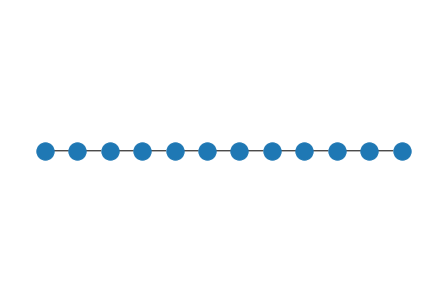

In [2]:
lattice = LineLattice(12)
lattice.draw()

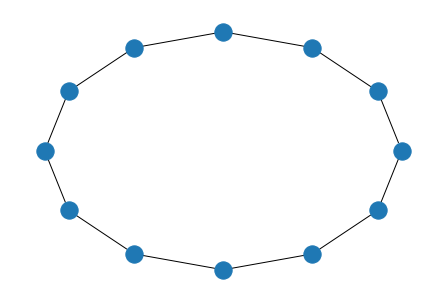

In [3]:
# single "heavy hex"
lattice = LineLattice(12, boundary_condition=BoundaryCondition.PERIODIC)
lattice.draw()

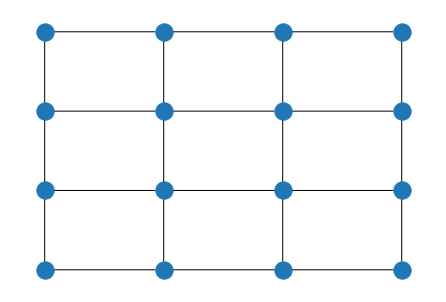

In [4]:
lattice = SquareLattice(4, 4)
lattice.draw()

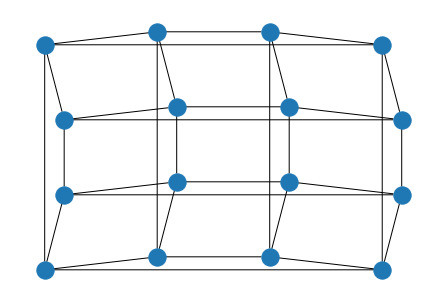

In [5]:
lattice = SquareLattice(4, 4, boundary_condition=BoundaryCondition.PERIODIC)
lattice.draw()

### Applying Models

In [6]:
from qiskit_nature.second_q.hamiltonians import IsingModel

ising = IsingModel(LineLattice(3).uniform_parameters(1, 2))
print(ising.second_q_op())

Spin Operator
spin=1/2, number spins=3, number terms=5
  1 * ( Z_0 Z_1 )
+ 1 * ( Z_1 Z_2 )
+ 2 * ( X_0 )
+ 2 * ( X_1 )
+ 2 * ( X_2 )


In [7]:
from qiskit_nature.second_q.hamiltonians import HeisenbergModel

heisenberg = HeisenbergModel(
    LineLattice(3).uniform_parameters(1, 2),
    coupling_constants=(2.0, 0.0, 0.0),
    ext_magnetic_field=(1.5, 0.0, 0.0),
)
print(heisenberg.second_q_op())

Spin Operator
spin=1/2, number spins=3, number terms=5
  2.0 * ( X_0 X_1 )
+ 2.0 * ( X_1 X_2 )
+ 1.5 * ( X_0 )
+ 1.5 * ( X_1 )
+ 1.5 * ( X_2 )


In [8]:
from qiskit_nature.second_q.hamiltonians import FermiHubbardModel

fermi_hubbard = FermiHubbardModel(
    LineLattice(3).uniform_parameters(1, 2),
    onsite_interaction=2.0,
)
print(fermi_hubbard.second_q_op())

Fermionic Operator
number spin orbitals=6, number terms=17
  1 * ( +_0 -_2 )
+ -1 * ( -_0 +_2 )
+ 1 * ( +_2 -_4 )
+ -1 * ( -_2 +_4 )
+ 2 * ( +_0 -_0 )
+ 2 * ( +_2 -_2 )
+ 2 * ( +_4 -_4 )
+ 1 * ( +_1 -_3 )
+ -1 * ( -_1 +_3 )
+ 1 * ( +_3 -_5 )
+ -1 * ( -_3 +_5 )
+ 2 * ( +_1 -_1 )
+ 2 * ( +_3 -_3 )
+ 2 * ( +_5 -_5 )
+ 2.0 * ( +_0 -_0 +_1 -_1 )
+ 2.0 * ( +_2 -_2 +_3 -_3 )
+ 2.0 * ( +_4 -_4 +_5 -_5 )


<img src="imgs/dynamics.png" width = 1300 height=1300 />

In [9]:
from qiskit_nature.second_q.mappers import LogarithmicMapper

mapper = LogarithmicMapper()

qubit_op = mapper.map(ising.second_q_op())

In [13]:
from qiskit_nature.second_q.operators import SpinOp

mag_z = mapper.map(SpinOp({f"Z_{idx}": 1 / 3 for idx in range(3)}))
mag_x = mapper.map(SpinOp({f"X_{idx}": 1 / 3 for idx in range(3)}))

In [14]:
from qiskit.algorithms import TimeEvolutionProblem

observables = [qubit_op, mag_z, mag_x]

problem = TimeEvolutionProblem(qubit_op, time=2, aux_operators=observables)

In [15]:
from qiskit.circuit.library import TwoLocal

ansatz = TwoLocal(
    3,
    rotation_blocks="rx",
    entanglement_blocks="rzz",
    entanglement="pairwise",
    insert_barriers=True,
    reps=2,
)

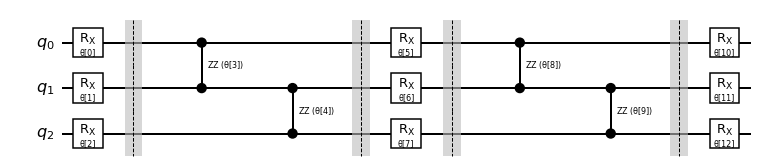

In [16]:
ansatz.decompose().draw("mpl", style="bw")

In [17]:
import numpy as np

initial_parameters = np.zeros(ansatz.num_parameters)

In [18]:
from qiskit.algorithms.optimizers import L_BFGS_B
from qiskit.algorithms.time_evolvers.pvqd import PVQD
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit_ibm_runtime import Sampler, Estimator, Session, QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum")

with Session(service, backend="simulator_statevector") as session:
    sampler = Sampler(session=session)
    estimator = Estimator(session=session)
    fidelity = ComputeUncompute(sampler)

    pvqd = PVQD(
        fidelity,
        ansatz,
        initial_parameters,
        estimator=estimator,
        optimizer=L_BFGS_B(),
        num_timesteps=100,
    )

    result = pvqd.evolve(problem)

In [21]:
from scipy.linalg import expm

observable_matrices = [op.to_matrix() for op in observables]

init_state = np.zeros(8)
init_state[0] = 1

exact = []
for t in result.times:
    exact.append(expm(observable_matrices[0] * -1j * t).dot(init_state))

In [ ]:
from matplotlib import pyplot as plt

plt.rcParams.update({"font.size": 22})

time_evolution, axs = plt.subplots(1, 3, figsize=(21, 7))

titles = ["Energy", "Mag. Z", "Mag. X"]
for i, title in enumerate(titles):
    axs[i].set_title(title)
    axs[i].set_xlabel("Time [s]")
    axs[i].plot(
        result.times,
        [np.real(s.conj().dot(observable_matrices[i].dot(s))) for s in exact],
        label="Exact",
    )
    axs[i].plot(
        result.times,
        [x[i] for x in result.observables],
        label="PVQD",
    )
    axs[i]
    axs[i].legend()

plt.close()

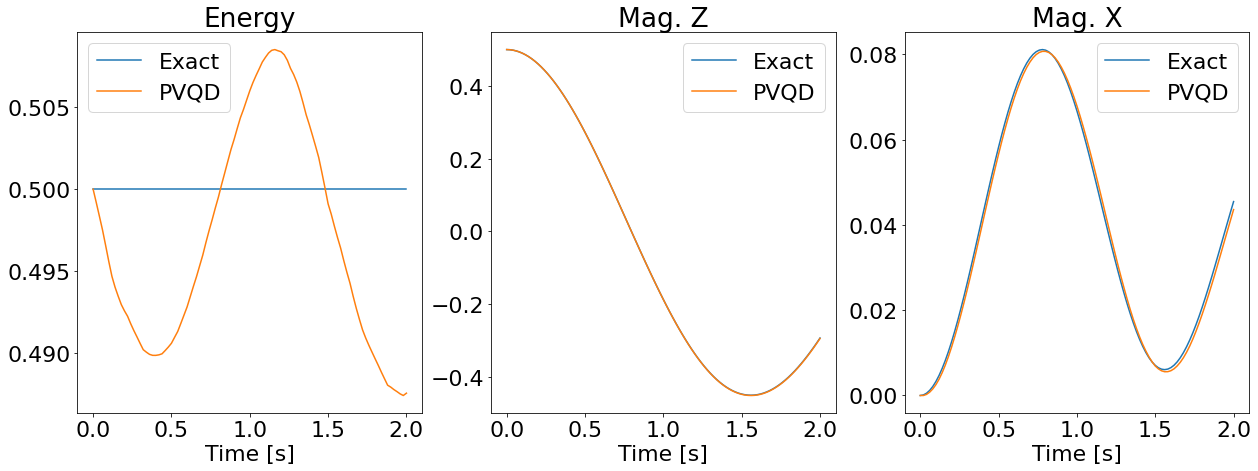

In [23]:
time_evolution

<a id='wrapup'></a>

<font color='gray'> 1. Introduction</font> 

<font color='gray'> 2. Algorithms

<font color='gray'> 3. Applications: Machine Learning. Performance</font> 

<font color='gray'> 4. Applications: Nature. Performance</font> 

# 5. Wrap-Up

[Top](#top)

<img src="imgs/wrap_up.png" width = 1500 height=1500 />

In [1]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright